mu: 0.6898595093270685
sigma: 0.13241694217637887
===>theta_arr = [1.5137857660965346, 2.588285148047836, 0.7303921254724792, 2.687564591255797, 1.8536781251531838, 1.2422966183738688, 0.9344741069997063, 2.477824527927441, 2.12621772620611, 1.83505137281193, 1.6168743384846267, 1.4589216677174028, 1.3449217962229048, 1.2619018953675438, 1.2007126145713434]


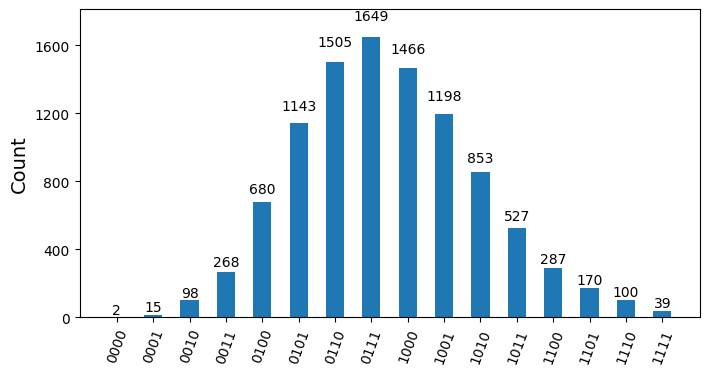

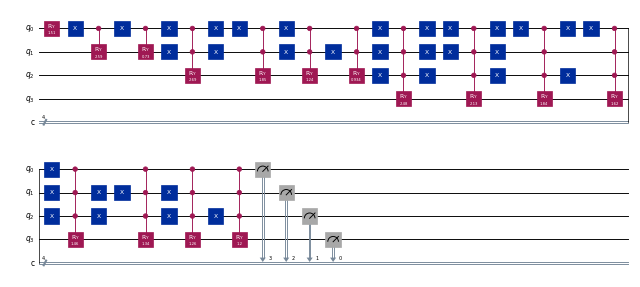

In [1]:
"""
Created on Sun Nov 10 23:30:42 2024

@author: haroune
"""

import numpy as np
import matplotlib.pyplot as plt
from qiskit_finance.circuit.library import LogNormalDistribution

from qiskit_aer import Aer
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import RYGate

# Parameters for considerd random distribution 
S = 2.0       # intial spot price
vol = 0.4     # volatility of 40%
r = 0.05      # annual interest rate of 4%
T = 40 / 365  # 40 days to maturity

# resulting parameters for log-normal distribution
mu = ((r - 0.5 * vol ** 2) * T + np.log(S))
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2/2)

print(f"mu: {mu}")
print(f"sigma: {sigma}")

N_QUBITS = 4

# number of qubit to represent distribution
num_uncertainty_qubits = N_QUBITS

# define range of plot
variance = (np.exp(sigma ** 2) - 1) * np.exp(2 * mu + sigma ** 2)
stddev = np.sqrt(variance)
low = np.maximum(0, mean - 3 * stddev)
high = mean + 3 * stddev

# Creation of a discreate ditribution accord with the number of qubits
uncertainty_model = LogNormalDistribution(
  num_uncertainty_qubits, mu=mu, sigma=sigma ** 2, bounds=(low, high)
)

# 1 qubits
if N_QUBITS >= 1:
    p0, p1 = np.array(np.array_split(uncertainty_model.probabilities, 2)).sum(axis=1)
    theta0 = 2 * np.arccos(np.sqrt(p0))
    theta_arr = [theta0]
# 2 qubits
if N_QUBITS >= 2:
    p00, p01, p10, p11 =\
        np.array(np.array_split(uncertainty_model.probabilities, 4)).sum(axis=1)
    theta1 = 2 * np.arccos(np.sqrt(p00 / p0))
    theta2 = 2 * np.arccos(np.sqrt(p10 / p1))
    theta_arr = [theta0, theta1, theta2]
# 3 qubits
if N_QUBITS >= 3:
    p000, p001, p010, p011, p100, p101, p110, p111 = \
        np.array(np.array_split(uncertainty_model.probabilities, 8)).sum(axis=1)
    theta3 = 2 * np.arccos(np.sqrt(p000 / p00))
    theta4 = 2 * np.arccos(np.sqrt(p010 / p01))
    theta5 = 2 * np.arccos(np.sqrt(p100 / p10))
    theta6 = 2 * np.arccos(np.sqrt(p110 / p11))
    theta_arr = [theta0, theta1, theta2, theta3, theta4, theta5, theta6]

# 4 qubits
if N_QUBITS >= 4:
    p0000, p0001, p0010, p0011, p0100, p0101, p0110, p0111, p1000, p1001, \
    p1010, p1011, p1100, p1101, p1110, p1111 = uncertainty_model.probabilities
    theta7 = 2 * np.arccos(np.sqrt(p0000 / p000))
    theta8 = 2 * np.arccos(np.sqrt(p0010 / p001))
    theta9 = 2 * np.arccos(np.sqrt(p0100 / p010))
    theta10 = 2 * np.arccos(np.sqrt(p0110 / p011))
    theta11 = 2 * np.arccos(np.sqrt(p1000 / p100))
    theta12 = 2 * np.arccos(np.sqrt(p1010 / p101))
    theta13 = 2 * np.arccos(np.sqrt(p1100 / p110))
    theta14 = 2 * np.arccos(np.sqrt(p1110 / p111))

    theta_arr = [theta0, theta1, theta2, theta3, theta4, theta5, theta6, theta7,
                 theta8, theta9, theta10, theta11, theta12, theta13, theta14]
    

def generate_permutations(n):
    """
    Generate permutations of bits of size n
    """
    perms = []
    perm = ['0' for i in range(n)]
    def backtrack(n, start, perm):
        cp = perm.copy()
        if cp not in perms:
            perms.append(cp)
        for i in range(start, n):
            perm[i] = '0' if perm[i] == '1' else '1'
            backtrack(n, start+1, perm)
            perm[i] = '0' if perm[i] == '1' else '1'
    backtrack(n, 0, perm)
    return perms

def prepare_control_qubits_bins(n):
    """
    Return an array of tuples containing all binary permutations of n values
    except the (0, 0, 0, ...) which stands for apply nothing
    """
    # Generate permutations (not sorted)
    perms = generate_permutations(n) 
    # Sort the permutations in the reverse order
    perms.sort(key=lambda elt: int(''.join(elt), 2) ) 
    # Reverse the whole list
    perms.reverse() 
    # Remove the [0, 0, ...] => no operation
    perms.pop()
    return perms

def apply_superposition(qc, n, theta):
    """
    qc: QuantumCircuit
    n: number of qubits
    thetha: array of n theta values: [t1, t2, ...]
    """
    if (n == 1): 
        # Single qubit => apply RY on first qubit
        qc.ry(theta[0], 0)
        return qc
    else:
        # More than 1 qubit 
        # 1: apply superposition on previous qubits
        # 2: Apply Not gate on previous qubits in all permutations
        # 3: Apply superpostion on current/last qubit
        # 4: Apply Not gate again to restore initial state
        apply_superposition(qc, n-1, theta)
        bin_perms = prepare_control_qubits_bins(n-1)
        # Applying RY gate using controlled qubits
        # We will use the permutations to have the right order
        
        l = [i for i in range(n)]
        start_indx = (2 ** (n - 1)) - 1  # The index that iterates over the corresponding theta values
        for perm in bin_perms:
            not_qubits = [] # List of qubits to apply not(X) on
            for indx, q in enumerate(perm):
                if q == '1':
                    not_qubits.append(indx)
            
            # Apply Not Gates
            qc.x(not_qubits)
            # Apply the RY Controlled Gate
            qc.append(RYGate(theta[start_indx]).control(n-1), l)
            start_indx += 1
            # Apply Not Gates agina (Undo the previous)
            qc.x(not_qubits)
            # Apply the RY Controlled Gate Again
            
            #qc.append(RYGate(theta[n-1]).control(n-1), l)
        qc.append(RYGate(theta[start_indx]).control(n-1), l)
        start_indx += 1        
            
        return qc
        
def cirtuit_bin(n):
  """Create |ψ1> state"""
  qc = QuantumCircuit(n, n)
  return qc    

qc = cirtuit_bin(N_QUBITS)
print(f"===>theta_arr = {theta_arr}")
qc = apply_superposition(qc, N_QUBITS, theta_arr)
# Measure Results
qubits_to_measure = [i for i in range(N_QUBITS)]
target_classical_bits = [N_QUBITS - 1 - i for i in range(N_QUBITS)]
for i in range(N_QUBITS):
    qc.measure(qubits_to_measure[i], target_classical_bits[i])
    
## EXECUTE    
backend = Aer.get_backend("qasm_simulator")
shots = 10000

transpiled_circuit = transpile(qc, backend=backend)
job = backend.run(transpiled_circuit, shots=shots, seed=1)
counts = job.result().get_counts()

# plot
ax1 = plt.figure(figsize=(8, 4), dpi=100, facecolor="w", linewidth=0, edgecolor="w"
).add_subplot(1, 1, 1)
ax2 = plt.figure(figsize=(8, 4), dpi=100, facecolor="w", linewidth=0, edgecolor="w"
).add_subplot(1, 1, 1)

plot_histogram(counts, ax=ax1)
qc.draw("mpl", ax=ax2)
